In [1]:
import mne
mne.set_log_level('error')
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# List with the ID of each participant
participants = [_ for _ in range(1,110)]

# List with the 14 experimet runs each participant did
run = [_ for _ in range(1,15)]  

# Creating a dictonary containing the raw data of a specific participant
participant = participants[16]
dic_runs = {}
for _ in run:
    file_path = f'files/S{participant:03}/S{participant:03}R{_:02}.edf'
    dic_runs[f'raw{_}'] = mne.io.read_raw_edf(file_path)

In [3]:
# Dictionary with the structure old_name : correct_cases_name. To respect the upper and lower cases of the standard notation for the electrde's position.
replacement = {
    'Fc': 'FC',
    'Cp': 'CP',
    'Af': 'AF',
    'Ft': 'FT',
    'Tp': 'TP',
    'Po': 'PO'   
}

# new_name is the dictionary to use to cange the name of the electrode's positions to respect the usual sandard notataions.
# First get rid of the excessive "." 
new_names = {
    name : name.replace(".", "") for name in dic_runs['raw1'].info['ch_names']
}

# Change the lower and upper case of the electrode's names
for key in new_names.keys():
    for old_string, new_string in replacement.items():
        new_names[key] = new_names[key].replace(old_string, new_string)

# Choose the montage and set it for the uploaded data
montage = 'standard_1020'
for _ in run:
        dic_runs[f'raw{_}'].rename_channels(new_names)
        dic_runs[f'raw{_}'].set_montage(montage)

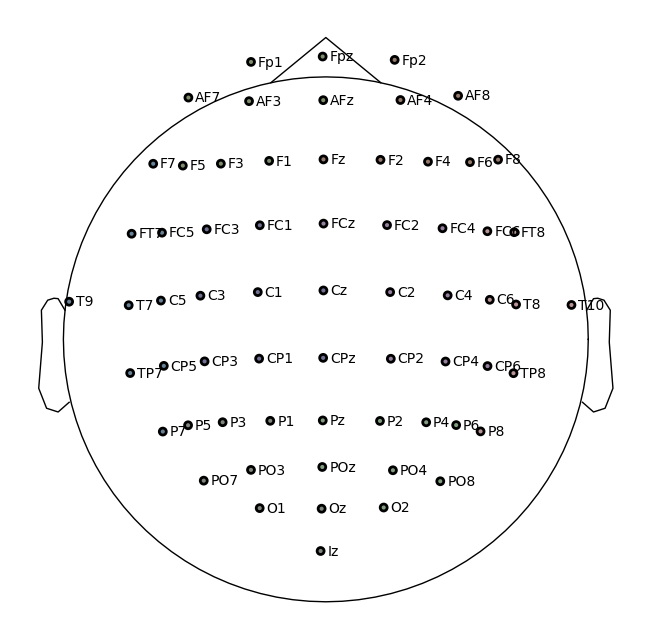

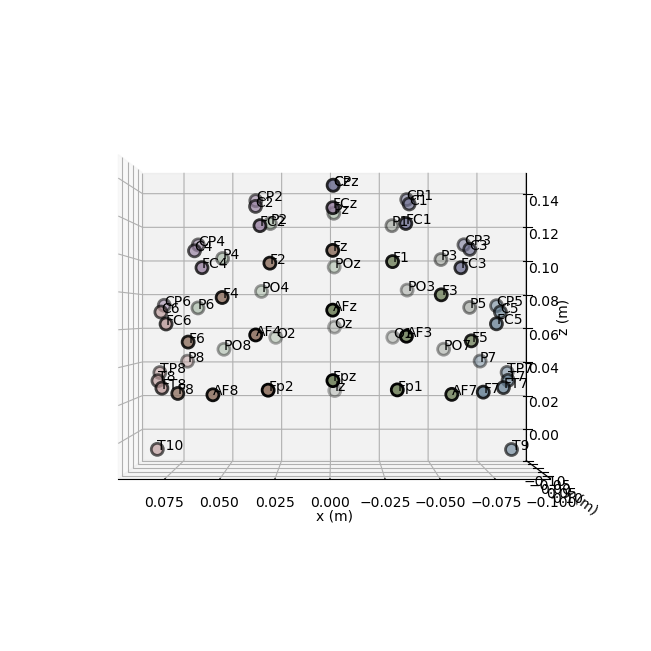

In [4]:
#  Show the placement of the electrodes
dic_runs['raw3'].info.plot_sensors(ch_type = 'eeg', show_names=True, ch_groups='position')
dic_runs['raw1'].info.plot_sensors(kind = "3d", ch_type = 'eeg', show_names=True, ch_groups='position')
plt.show()



In [5]:
# Filter setting
low_cut = 0.1
high_cut = 30

# copy the raw data and apply the filter
raw_filt = dic_runs['raw3'].load_data().copy().filter(low_cut, high_cut)

/home/elia/anaconda3/envs/mne/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


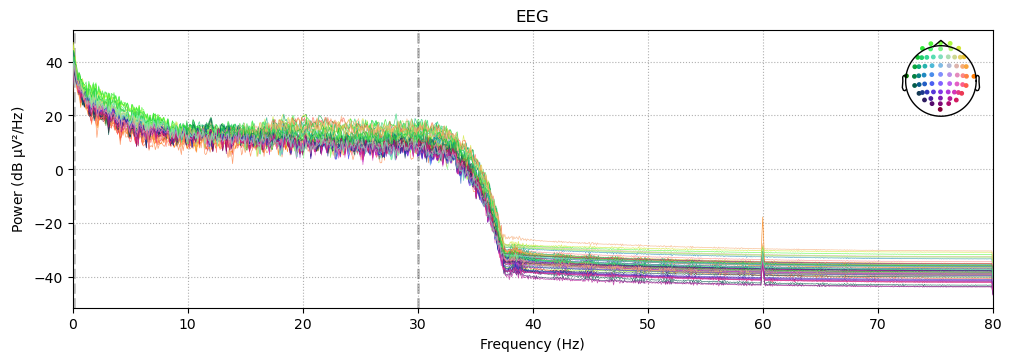

In [6]:
# Plot the power graph of the raw data filtered
raw_filt.compute_psd().plot()
plt.show()

# ICA

In [7]:
# Filter settings for ICA
ica_low_cut = 1.0
high_cut = 30

raw_ica = dic_runs['raw3'].copy().filter(ica_low_cut, high_cut)

In [8]:
time_step = 1.0
events_ica = mne.make_fixed_length_events(raw_ica, duration=time_step)
epochs_ica = mne.Epochs(raw_ica, events_ica,
                        tmin=0.0, tmax=time_step,
                        baseline=None,
                        preload=True)

In [9]:
dic_runs['raw3'].info

<Info | 9 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: 3 items (dict)
>

In [10]:
epochs_ica

<Epochs | 122 events (all good), 0 – 1 s (baseline off), ~9.7 MB, data loaded,
 '1': 122>

In [11]:
# Here we veryfy the epochs
epochs_ica.plot(group_by=('position'))

In [12]:
from autoreject import AutoReject

ar = AutoReject(n_interpolate=[1, 2, 4],
                random_state=42,
                picks=mne.pick_types(epochs_ica.info, 
                                     eeg=True,
                                     eog=False
                                    ),
                n_jobs=-1, 
                verbose=False
                )

ar.fit(epochs_ica)

reject_log = ar.get_reject_log(epochs_ica)

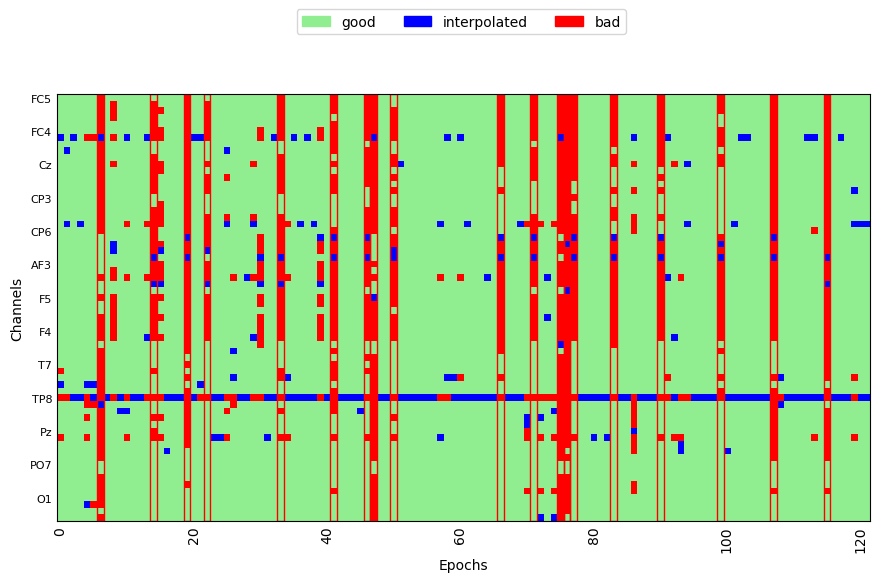

In [13]:
reject_log.plot('horizontal')
plt.show()

In [14]:
epochs_ica[reject_log.bad_epochs].plot()

In [15]:
# ICA parameters
random_state = 42   # ensures ICA is reproducible each time it's run
ica_n_components = .99     # Specify n_components as a decimal to set % explained variance

# Fit ICA
ica = mne.preprocessing.ICA(n_components=ica_n_components,
                            random_state=random_state,
                            )
ica.fit(epochs_ica[~reject_log.bad_epochs], decim=3)

/home/elia/anaconda3/envs/mne/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


<ICA | epochs decomposition, method: fastica (fit in 1000 iterations on 5562 samples), 40 ICA components (64 PCA components available), channel types: eeg, no sources marked for exclusion>

In [ ]:
ica.plot_properties(epochs_ica, picks=range(0, ica.n_components_), psd_args={'fmax': high_cut})

In [16]:
ica.exclude = []
num_excl = 0
max_ic = 2
z_thresh = 3.5
z_step = .05

while num_excl < max_ic:
    eog_indices, eog_scores = ica.find_bads_eog(epochs_ica,
                                                ch_name=['Fp1', 'Fp2', 'F7', 'F8'], 
                                                threshold=z_thresh
                                                )
    num_excl = len(eog_indices)
    z_thresh -= z_step # won't impact things if num_excl is ≥ n_max_eog 

# assign the bad EOG components to the ICA.exclude attribute so they can be removed later
ica.exclude = eog_indices

print('Final z threshold = ' + str(round(z_thresh, 2)))

Final z threshold = 3.45


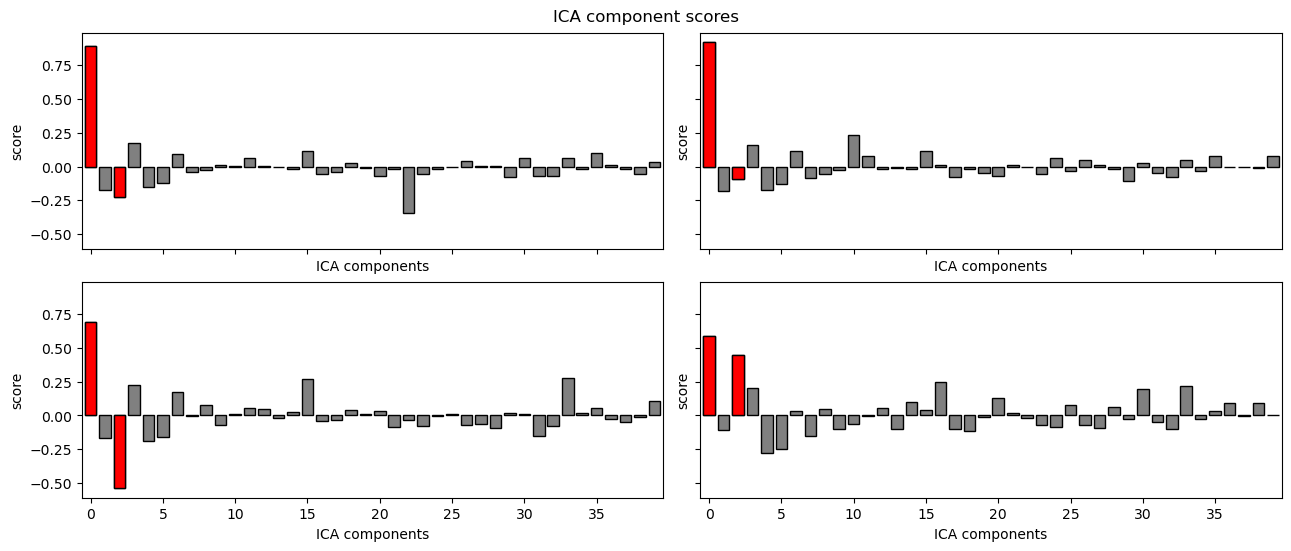

In [17]:
ica.plot_scores(eog_scores);

# ERP SEGMENTATION

In [18]:
events, events_dict = mne.events_from_annotations(raw_filt)

In [19]:
events[:10]

array([[   0,    0,    1],
       [ 656,    0,    3],
       [1312,    0,    1],
       [1968,    0,    2],
       [2624,    0,    1],
       [3280,    0,    2],
       [3936,    0,    1],
       [4592,    0,    3],
       [5248,    0,    1],
       [5904,    0,    2]])

In [20]:
events_dict

{'T0': 1, 'T1': 2, 'T2': 3}

In [22]:
mne.events_from_annotations(dic_runs['raw3'])

(array([[    0,     0,     1],
        [  656,     0,     3],
        [ 1312,     0,     1],
        [ 1968,     0,     2],
        [ 2624,     0,     1],
        [ 3280,     0,     2],
        [ 3936,     0,     1],
        [ 4592,     0,     3],
        [ 5248,     0,     1],
        [ 5904,     0,     2],
        [ 6560,     0,     1],
        [ 7216,     0,     3],
        [ 7872,     0,     1],
        [ 8528,     0,     2],
        [ 9184,     0,     1],
        [ 9840,     0,     3],
        [10496,     0,     1],
        [11152,     0,     2],
        [11808,     0,     1],
        [12464,     0,     3],
        [13120,     0,     1],
        [13776,     0,     3],
        [14432,     0,     1],
        [15088,     0,     2],
        [15744,     0,     1],
        [16400,     0,     3],
        [17056,     0,     1],
        [17712,     0,     2],
        [18368,     0,     1],
        [19024,     0,     2]]),
 {'T0': 1, 'T1': 2, 'T2': 3})

In [25]:
event_mapping = {
    1: 'rest',
    2: 'left_fist',
    3: 'right_fist'
}

event_id = {v:k for k,v in event_mapping.items()}

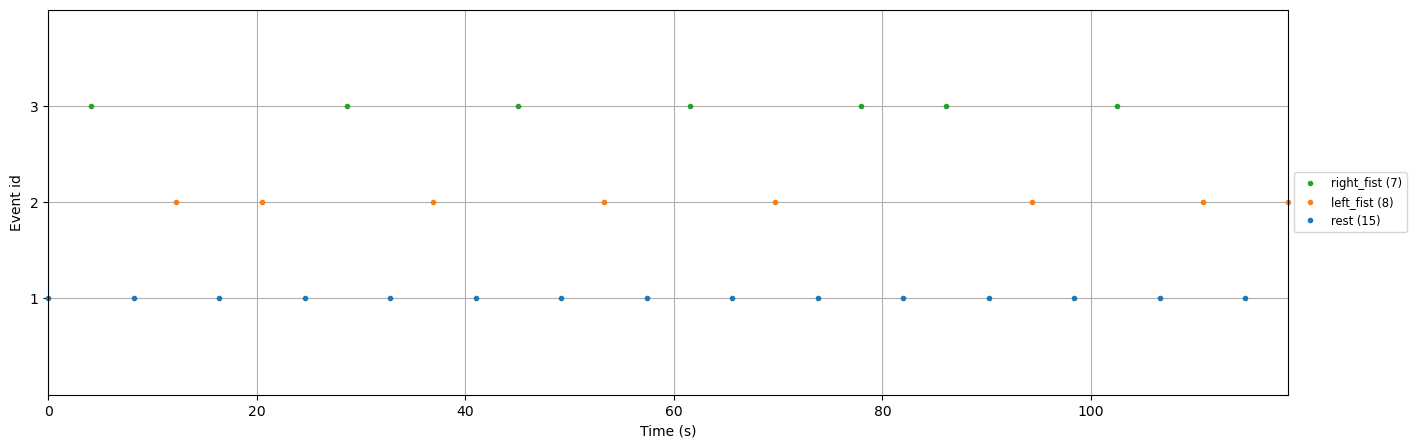

In [28]:
fig, ax = plt.subplots(figsize=[20, 5])

mne.viz.plot_events(events, raw_filt.info['sfreq'],  
                    event_id=event_id,                    
                    axes=ax)
plt.show()


In [40]:
raw_filt

<RawEDF | S017R03.edf, 64 x 19680 (123.0 s), ~9.7 MB, data loaded>

In [31]:
epoch_duration = 656. / raw_filt.info['sfreq']
epoch_duration

4.1

In [34]:
# Epoching settings
tmin =  0.  # start of each epoch (in sec)
tmax =  4.1  # end of each epoch (in sec)
baseline = (0, 0)

# Create epochs
epochs = mne.Epochs(raw_filt,
                    events, event_id,
                    tmin, tmax,
                    baseline=baseline, 
                    preload=True
                   ) 

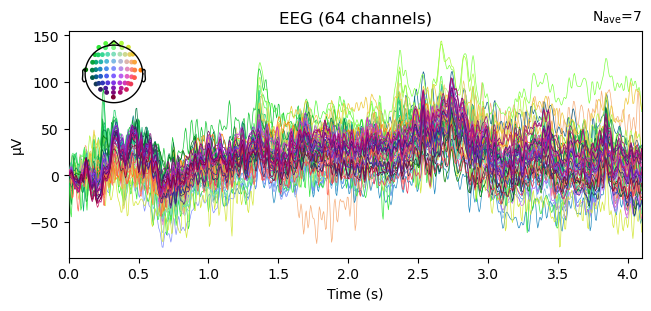

In [116]:

# picks = [
#  'C5',
#  'C3',
#  'C1',
#  'Cz',
#  'C2',
#  'C4',
#  'C6',
# ]

epochs['left_fist'].average().plot(); # remember the semicolon prevents a duplicated plot



In [104]:
epochs_postica = ica.apply(epochs.copy())

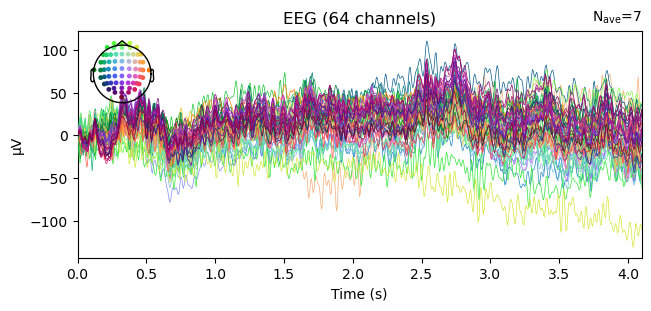

In [143]:
# picks = [
#  'C5',
#  'C3',
#  'C1',
#  'Cz',
#  'C2',
#  'C4',
#  'C6',
# ]

epochs_postica['left_fist'].average().plot();


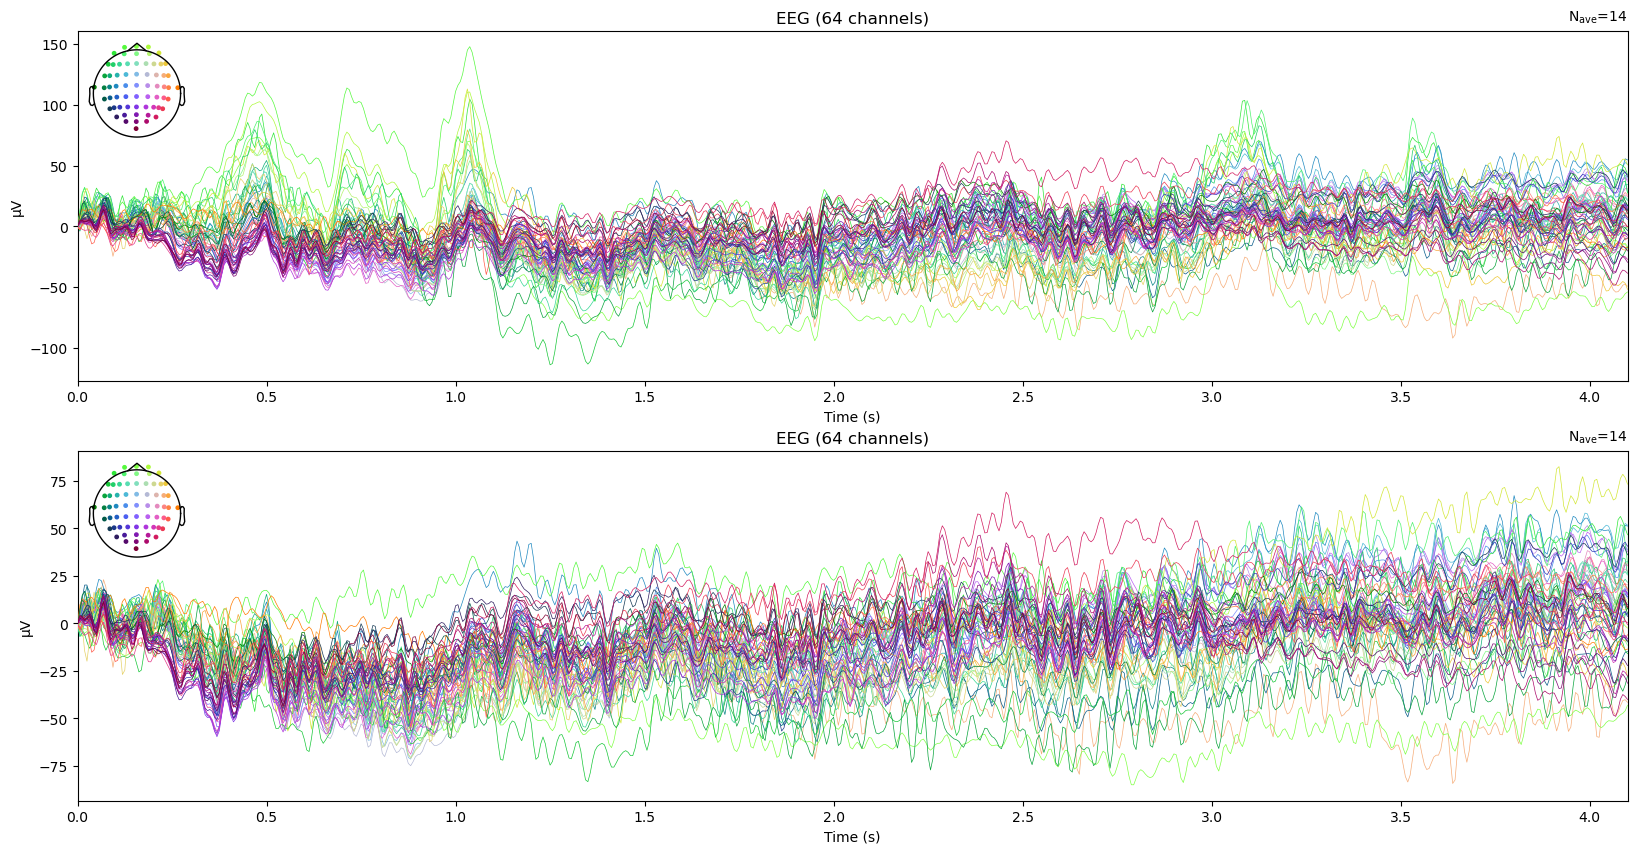

In [125]:
fig, ax = plt.subplots(2, 1, figsize=[20, 10])

epochs['rest'].average().plot(axes=ax[0], show=False); # remember the semicolon prevents a duplicated plot
epochs_postica['rest'].average().plot(axes=ax[1]);

In [144]:


ar = AutoReject(n_interpolate=[1, 2, 4],
                random_state=42,
                picks=mne.pick_types(epochs_postica.info, 
                                     eeg=True,
                                     eog=False
                                    ),
                n_jobs=-1, 
                verbose=False
                )

epochs_clean, reject_log_clean = ar.fit_transform(epochs_postica, return_log=True)

epochs_clean

<Epochs | 28 events (all good), 0 – 4.1 s (baseline 0 – 0 s), ~9.1 MB, data loaded,
 'rest': 14
 'left_fist': 7
 'right_fist': 7>

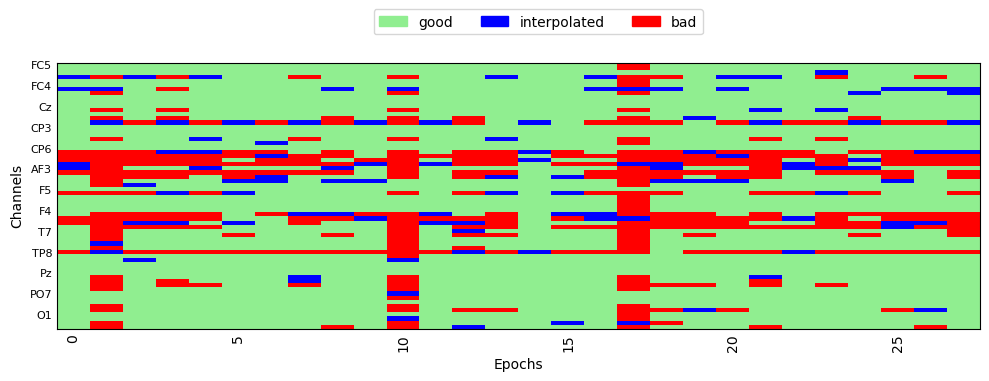

In [145]:
fig, ax = plt.subplots(figsize=[10, 4])
reject_log_clean.plot('horizontal', aspect='auto', ax=ax)
plt.show()


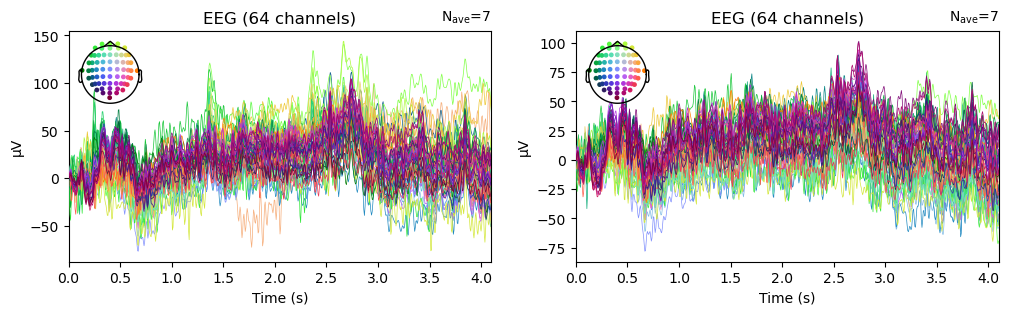

In [146]:
fig, ax = plt.subplots(1, 2, figsize=[12, 3])

epochs['left_fist'].average().plot(axes=ax[0], show=False); # remember the semicolon prevents a duplicated plot
epochs_clean['left_fist'].average().plot(axes=ax[1]);

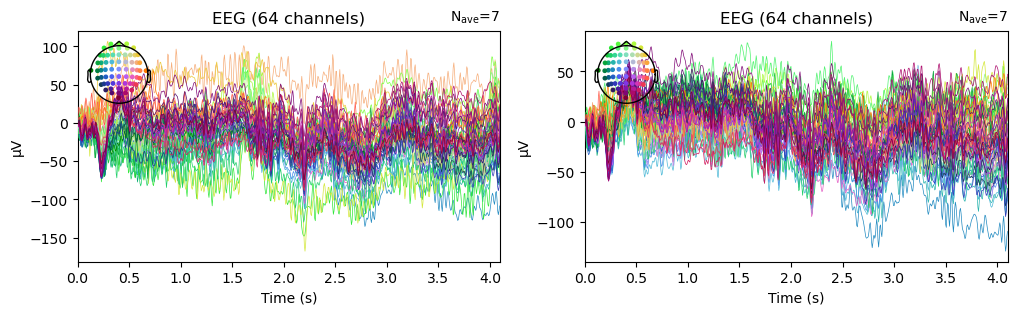

In [148]:
fig, ax = plt.subplots(1, 2, figsize=[12, 3])

epochs['right_fist'].average().plot(axes=ax[0], show=False); # remember the semicolon prevents a duplicated plot
epochs_clean['right_fist'].average().plot(axes=ax[1]);

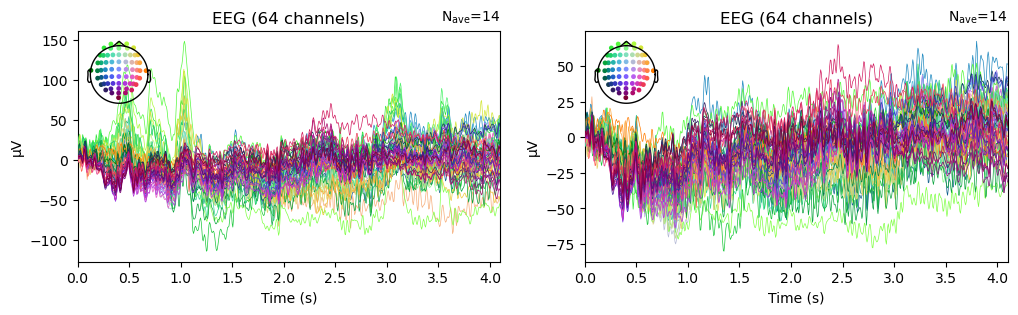

In [149]:
fig, ax = plt.subplots(1, 2, figsize=[12, 3])

epochs['rest'].average().plot(axes=ax[0], show=False); # remember the semicolon prevents a duplicated plot
epochs_clean['rest'].average().plot(axes=ax[1]);

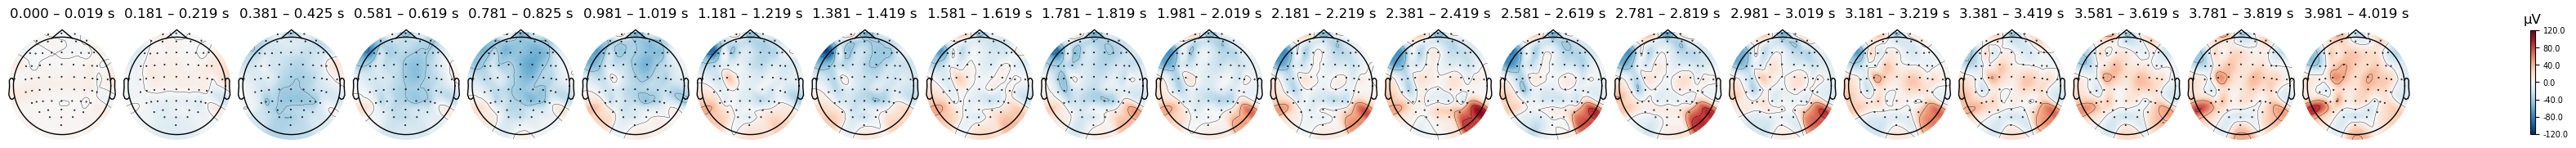

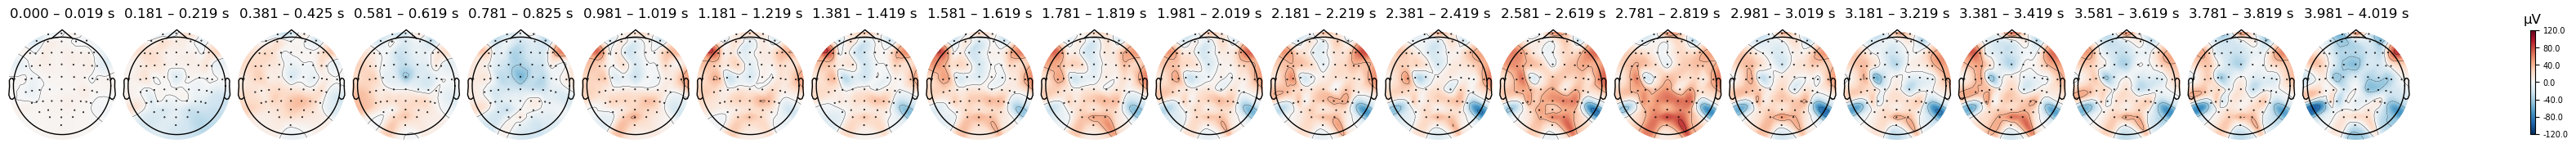

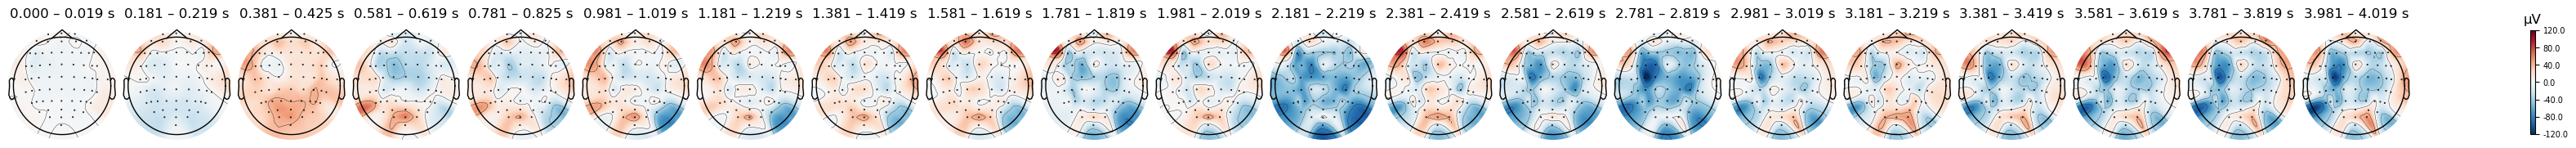

In [160]:
# Specify times to plot at, as [min],[max],[stepsize]
times = np.arange(0, tmax, 0.2)

epochs_clean['rest'].average().plot_topomap(times=times, average=0.05, vlim=(-120, 120));
epochs_clean['left_fist'].average().plot_topomap(times=times, average=0.05, vlim=(-120, 120));
epochs_clean['right_fist'].average().plot_topomap(times=times, average=0.05, vlim=(-120, 120));

This images shows that when moving moving the left hand the polarity is inversed compared to when the subject is moving the right hand. It may seems that this difference starts 2s, but in reality the scales of uV are differents in the 3 picture.